In [1]:
%pip install opencv-python

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   -- ------------------------------------- 2.4/39.5 MB 12.2 MB/s eta 0:00:04
   ----- ---------------------------------- 5.0/39.5 MB 11.6 MB/s eta 0:00:03
   ------ --------------------------------- 6.6/39.5 MB 10.6 MB/s eta 0:00:04
   -------- ------------------------------- 8.7/39.5 MB 10.1 MB/s eta 0:00:04
   ----------- ---------------------------- 11.0/39.5 MB 10.3 MB/s eta 0:00:03
   ------------- -------------------------- 13.6/39.5 MB 10.6 MB/s eta 0:00:03
   ---------------- ----------------------- 16.0/39.5 MB 10.6 MB/s eta 0:00:03
   ------------------ --------------------- 18.6/39.5 MB 10.8 MB/s eta 0:00:02
   --------------------- ------------------ 21.0/39.5 MB 10.9 MB/s eta 0:00:02
   ----------------------- ---------------- 23.3/39.5 MB 10.9 MB/s eta 0:00:02
   -------------------------- ------------- 26.0/39.5 MB 11.0 MB/s eta 0:00:02
   ---------------------------- ----------- 28.3/39.5 MB 11.1 MB/

In [5]:
import os

# Define dataset paths
DATASET_PATHS = {
    "begin": "begin",
    "early": "early",
    "pre": "pre",
    "post": "pro"
}

# Check each folder
for class_name, path in DATASET_PATHS.items():
    if os.path.exists(path):
        num_images = len(os.listdir(path))
        print(f"✅ Found folder: {class_name}, containing {num_images} images.")
    else:
        print(f"⚠ Folder '{class_name}' NOT found!")

✅ Found folder: begin, containing 509 images.
✅ Found folder: early, containing 985 images.
✅ Found folder: pre, containing 966 images.
✅ Found folder: post, containing 827 images.


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# 1. Set up parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 4
VALIDATION_SPLIT = 0.2

# 2. Paths to your separate folders (replace with your actual paths)
data_dirs = {
    'begin': 'begin',
    'early': 'early',
    'pre': 'pre',
    'post': 'pro'
}

# 3. Load data from flat directories
def load_data():
    train_data = []
    train_labels = []
    val_data = []
    val_labels = []
    class_names = ['begin', 'early', 'pre', 'post']
    
    for idx, (class_name, directory) in enumerate(data_dirs.items()):
        if not os.path.exists(directory):
            raise FileNotFoundError(f"Directory not found: {directory}")
        
        image_files = [os.path.join(directory, f) for f in os.listdir(directory) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if not image_files:
            print(f"Warning: No images found in {directory}")
            continue
        
        print(f"Found {len(image_files)} images in {class_name}")
        
        # Shuffle and split
        np.random.shuffle(image_files)
        split_idx = int(len(image_files) * (1 - VALIDATION_SPLIT))
        
        # Load training images
        for img_path in image_files[:split_idx]:
            try:
                img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
                img_array = image.img_to_array(img) / 255.0
                train_data.append(img_array)
                train_labels.append(idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
        
        # Load validation images
        for img_path in image_files[split_idx:]:
            try:
                img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
                img_array = image.img_to_array(img) / 255.0
                val_data.append(img_array)
                val_labels.append(idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    if not train_data or not val_data:
        raise ValueError("No valid data loaded. Check your image files and directories.")
    
    # Convert to numpy arrays and one-hot encode labels
    train_data = np.array(train_data)
    train_labels = tf.keras.utils.to_categorical(train_labels, NUM_CLASSES)
    val_data = np.array(val_data)
    val_labels = tf.keras.utils.to_categorical(val_labels, NUM_CLASSES)
    
    print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}")
    
    # Create tensorflow datasets with augmentation
    train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
    
    def augment(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.rot90(image, k=np.random.randint(4))
        image = tf.image.random_brightness(image, max_delta=0.1)
        return image, label
    
    train_dataset = (train_dataset
                    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
                    .shuffle(buffer_size=1000)
                    .batch(BATCH_SIZE)
                    .repeat()  # Ensure dataset doesn't run out
                    .prefetch(tf.data.AUTOTUNE))
    
    val_dataset = (val_dataset
                  .batch(BATCH_SIZE)
                  .repeat()  # Ensure dataset doesn't run out
                  .prefetch(tf.data.AUTOTUNE))
    
    return train_dataset, val_dataset

# 4. Create model with VGG16 backbone
def create_transfer_model():
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

# 5. Load data and create model
try:
    train_dataset, val_dataset = load_data()
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

model = create_transfer_model()

# 6. Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 7. Display model summary
model.summary()

# 8. Calculate steps per epoch
total_images = sum([len([f for f in os.listdir(dir) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))]) 
                   for dir in data_dirs.values()])
train_steps = max(1, int(total_images * (1 - VALIDATION_SPLIT)) // BATCH_SIZE)
val_steps = max(1, int(total_images * VALIDATION_SPLIT) // BATCH_SIZE)

print(f"Train steps: {train_steps}, Validation steps: {val_steps}")

# 9. Train the model with callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    validation_data=val_dataset,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

# 10. Fine-tuning
base_model = model.layers[0]
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 10
history_fine = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    epochs=fine_tune_epochs,
    validation_data=val_dataset,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

# 11. Save the final model
model.save('cancer_stage_classifier_vgg16_final.h5')

# 12. Prediction function
def predict_image(image_path):
    img = image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    prediction = model.predict(img_array)
    class_names = ['begin', 'early', 'pre', 'post']
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = np.max(prediction[0])
    
    return predicted_class, confidence

Found 509 images in begin
Found 985 images in early
Found 966 images in pre
Found 827 images in post
Training samples: 2628, Validation samples: 659
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512

Model loaded successfully!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             

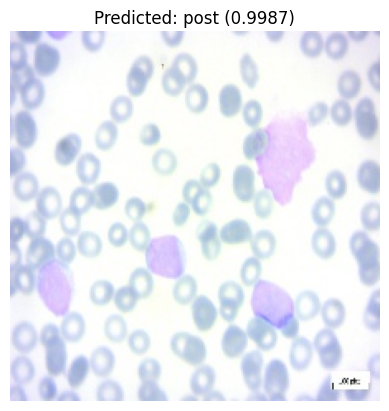

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import matplotlib.pyplot as plt

# 1. Parameters (must match training parameters)
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CLASSES = 4
CLASS_NAMES = ['begin', 'early', 'pre', 'post']

# 2. Load the trained model
def load_trained_model(model_path='cancer_stage_classifier_vgg16_final.h5'):
    try:
        model = load_model(model_path)
        print("Model loaded successfully!")
        model.summary()  # Display model architecture
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# 3. Predict on a single image
def predict_single_image(model, image_path):
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None, None
    
    try:
        # Load and preprocess the image
        img = image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        
        # Make prediction
        prediction = model.predict(img_array, verbose=0)
        predicted_class = CLASS_NAMES[np.argmax(prediction[0])]
        confidence = np.max(prediction[0])
        
        # Display results
        print(f"\nPrediction for {os.path.basename(image_path)}:")
        print(f"Predicted class: {predicted_class}")
        print(f"Confidence: {confidence:.4f}")
        
        # Show image with prediction
        plt.figure()
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class} ({confidence:.4f})")
        plt.axis('off')
        plt.show()
        
        return predicted_class, confidence
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None

# 4. Predict on multiple images (batch testing)
def predict_batch_images(model, image_dir):
    if not os.path.exists(image_dir):
        print(f"Directory not found: {image_dir}")
        return
    
    image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_files:
        print(f"No images found in {image_dir}")
        return
    
    print(f"\nTesting {len(image_files)} images from {image_dir}")
    
    predictions = []
    for img_path in image_files:
        try:
            img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0
            
            prediction = model.predict(img_array, verbose=0)
            predicted_class = CLASS_NAMES[np.argmax(prediction[0])]
            confidence = np.max(prediction[0])
            
            predictions.append((os.path.basename(img_path), predicted_class, confidence))
            
            print(f"Image: {os.path.basename(img_path)}")
            print(f"Predicted: {predicted_class}, Confidence: {confidence:.4f}")
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    
    # Summary of batch predictions
    print("\nBatch Prediction Summary:")
    for img_name, pred_class, conf in predictions:
        print(f"{img_name}: {pred_class} ({conf:.4f})")

# 5. Main execution
if __name__ == "__main__":
    # Load the model
    model = load_trained_model('cancer_stage_classifier_vgg16_final.h5')
    if model is None:
        exit()
    
    # Option 1: Test a single image
    test_image_path = 'test3.jpg' 
    predict_single_image(model, test_image_path)
    
    # Option 2: Test a batch of images (uncomment to use)
    # test_dir = 'path_to_test_folder'  # Replace with your test folder path
    # predict_batch_images(model, test_dir)

In [3]:
%pip install fpdf

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40768 sha256=f516b295c8afa60a644e0a6d182f0aa159b4d28fd9016e16c32560c1a90bd393
  Stored in directory: c:\users\ajay sivakumar\appdata\local\pip\cache\wheels\f9\95\ba\f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf
Note: you may need to restart the kernel to use updated packages.


c:\Users\AJAYSI~1\anaconda3\envs\ai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


CNN Model loaded successfully!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)         

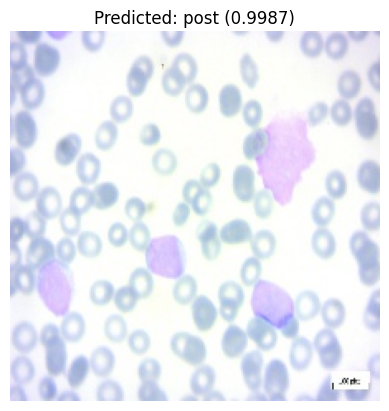

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


📝 Medical Advice:
 *Stage Meaning*: Cancer is classified into five stages based on its spread. Stage 4 cancer means the cancer has spread to distant parts of the body, such as the liver, lungs, or bones. This stage is also known as advanced cancer or metastatic cancer. At this stage, the cancer is no longer localized and has spread to other areas, making treatment more challenging.

     *Treatment Plan*: For stage 4 cancer, treatment options may include:
     - Chemotherapy: to kill cancer cells
     - Targeted therapy: to target specific cancer cells
     - Immunotherapy: to boost the immune system's ability to fight cancer
     - Hormone therapy: to block hormones that promote cancer growth
     - Radiation therapy: to kill cancer cells
     - Clinical trials: to test new and experimental treatments

     *Diet Plan*: A healthy diet can help manage symptoms and improve quality of life. Recommended foods include:
     - Fruits and vegetables: rich in antioxidants and fiber
     - Who

In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from fpdf import FPDF

# --- CNN Model Parameters ---
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CLASSES = 4
CLASS_NAMES = ['begin', 'early', 'pre', 'post']

# --- Load LLaMA-3B Model ---
model_name = "g:\My Drive\llama-3.2-3b-instruct"  # Update this path as needed
tokenizer = AutoTokenizer.from_pretrained(model_name)
llama_model = AutoModelForCausalLM.from_pretrained(model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
llama_model.to(device)

# 1. Load the trained CNN model
def load_trained_model(model_path='cancer_stage_classifier_vgg16_final.h5'):
    try:
        model = load_model(model_path)
        print("CNN Model loaded successfully!")
        model.summary()
        return model
    except Exception as e:
        print(f"Error loading CNN model: {e}")
        return None

# 2. Predict on a single image and get medical advice
def predict_and_get_advice(model, image_path):
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None, None, None
    
    try:
        # Load and preprocess the image
        img = image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        
        # CNN Prediction
        prediction = model.predict(img_array, verbose=0)
        predicted_class = CLASS_NAMES[np.argmax(prediction[0])]
        confidence = np.max(prediction[0])
        
        print(f"\nPrediction for {os.path.basename(image_path)}:")
        print(f"Predicted class: {predicted_class}")
        print(f"Confidence: {confidence:.4f}")
        
        # Display image
        plt.figure()
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class} ({confidence:.4f})")
        plt.axis('off')
        plt.show()
        
        # Get medical advice from LLaMA
        ai_response = get_medical_advice(predicted_class)
        print("📝 Medical Advice:\n", ai_response)
        
        # Generate PDF report
        generate_pdf_report(predicted_class, ai_response)
        
        return predicted_class, confidence, ai_response
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None, None

# 3. Batch prediction with medical advice
def predict_batch_and_get_advice(model, image_dir):
    if not os.path.exists(image_dir):
        print(f"Directory not found: {image_dir}")
        return
    
    image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_files:
        print(f"No images found in {image_dir}")
        return
    
    print(f"\nTesting {len(image_files)} images from {image_dir}")
    
    for img_path in image_files:
        predicted_class, confidence, ai_response = predict_and_get_advice(model, img_path)

# 4. LLaMA Medical Advice Function
def get_medical_advice(stage):
    prompt = f"""
    You are a medical AI assistant. The patient has been diagnosed with {stage} stage cancer.
    
    Provide the following details:
    1️⃣ *Stage Meaning* – Explain what this stage means.
    2️⃣ *Treatment Plan* – List recommended treatments.
    3️⃣ *Diet Plan* – Suggest foods to eat/avoid.
    4️⃣ *Precautions* – Provide health precautions.

    Respond in a professional but simple way.

    ### Response:
    """
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        output = llama_model.generate(**inputs, max_length=1024)
    
    full_output = tokenizer.decode(output[0], skip_special_tokens=True)
    split_output = full_output.split("### Response:")
    ai_response = split_output[1].strip() if len(split_output) > 1 else full_output.strip()
    
    return ai_response

# 5. Generate PDF Report
def generate_pdf_report(stage, ai_response):
    pdf = FPDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()

    pdf.set_font("Arial", "B", 16)
    pdf.cell(200, 10, "Medical Report", ln=True, align="C")
    pdf.ln(10)

    pdf.set_font("Arial", "B", 14)
    pdf.cell(200, 10, f"Cancer Stage: {stage.upper()}", ln=True)
    pdf.ln(5)

    # Use a Unicode font for special characters (adjust path if needed)
    try:
        pdf.add_font('FreeSans', '', '/usr/share/fonts/truetype/freefont/FreeSans.ttf', uni=True)
        pdf.set_font("FreeSans", size=11)
    except:
        pdf.set_font("Arial", size=11)  # Fallback to Arial if font not found
    
    pdf.multi_cell(0, 10, ai_response)

    pdf_filename = f"cancer_{stage}_report.pdf"
    pdf.output(pdf_filename)
    print(f"✅ PDF Generated: {pdf_filename}")

# 6. Main execution
if __name__ == "__main__":
    # Load the CNN model
    cnn_model = load_trained_model('cancer_stage_classifier_vgg16_final.h5')
    if cnn_model is None:
        exit()
    
    # Test a single image
    test_image_path = 'test3.jpg'  # Replace with your test image path
    predict_and_get_advice(cnn_model, test_image_path)
    
    # Test a batch of images (uncomment to use)
    # test_dir = 'path_to_test_folder'  # Replace with your test folder path
    # predict_batch_and_get_advice(cnn_model, test_dir)